In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
#PROBLEM FORMULATION
#The problem is supervised text classification problem, and our goal is to investigate which supervised machine learning 
#methods are best suited to solve it.
#Given a new complaint comes in, we want to assign it to one of 12 categories.

In [75]:
#PART 01 :
#DATA EXPLORATION 
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Consumer_Complaints.csv')
#remove all column except input and output 
col = ['Product', 'Consumer Complaint']
df= df[col]
#remove null review comments 
df= df[pd.notnull(df['Consumer Complaint'])]
#rename the column from Consumer Complaint to Consumer_complaint
df.columns=['Product', 'Consumer_complaint']
#factorize the product and rename with categoryid 
df['category_id'] = df['Product'].factorize()[0]
#remove duplicates 
#remove product id 
df =df.drop(df.loc[:,['Product']], axis =1 )
df=df.drop_duplicates()

df.head()

,Consumer_complaint,category_id
1,I have outdated information on my credit repor...,0
2,I purchased a new car on XXXX XXXX. The car de...,1
7,An account on my credit report has a mistaken ...,0
12,This company refuses to provide me verificatio...,2
16,This complaint is in regards to Square Two Fin...,2


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2110 entries, 1 to 9998
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Consumer_complaint  2110 non-null   object
 1   category_id         2110 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 49.5+ KB


In [77]:
df['category_id'].value_counts()

2     518
3     407
0     392
4     270
6     185
7     145
1     108
9      26
8      22
10     18
12      9
5       4
13      2
11      2
15      1
14      1
Name: category_id, dtype: int64

In [78]:
#DATA CLEANING 
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [79]:
def clean_text(df):
    all_reviews = list()
    lines = df["Consumer_complaint"].values.tolist()
    for text in lines:
        text = text.lower()
        text = re.sub('[^a-zA-Z]', ' ', text)
        text = text.replace('x', '')
        #remove single character 
        text = re.sub('\s\w\s',' ',text)
        words=nltk.word_tokenize(text)
        stop_words= set(stopwords.words('english'))
        stop_words.discard("not")
        words_without_stop_words=[word for word in words if word not in stop_words]
        #words=[lemmatizer.lemmatize(word) for word in words_without_stop_words ]
        words=[ps.stem(word) for word in words_without_stop_words ]
        words = ' '.join(words)
        all_reviews.append(words)
    return all_reviews

all_complaint = clean_text(df)
all_complaint[0:20]

['outdat inform credit report previous disput yet remov inform seven year old not meet credit report requir',
 'purchas new car car dealer call citizen bank get day payoff loan good till dealer sent check net day balanc checkbook notic citizen bank taken automat payment check account bank call citizen state not close loan state not receiv check told not believ check took long arriv told check issu amount overpaid deduct addit interest today call citizen bank talk supervisor name receiv letter loan paid full date refund check includ state hold payment busi day loan satisfi check would mail wed question delay post dealer payment first state sometim take busi day post said not receiv check till told not believ ask money state hold payment busi day ask simpli said polici ask would receiv interest money state believ citizen bank deliber delay post payment return consum money make addit interest bank not illeg hurt consum not ethic amount money lost minim thousand car loan month addit intere

In [80]:
#FIRST We will make all text data into numrical and of same length 
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

In [81]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences 
#Word Embedding is a representation of text where words that have the same meaning have a similar representation.Embedding layers 
#hrlps to represnts text in vector format 
#pad sequences to make vector of equal length if vector is not that much length then 0s will be added 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.layers import Dense 
import gensim
import os
from tensorflow.python.keras.preprocessing.text import Tokenizer

In [82]:
#number of words in each review/ happymoments/sentence=55
validation_split = 0.2
max_length = 80
#tokenize te sentences and represent them in numbers other way is to todo one hot 
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(all_complaint)
sequences = tokenizer_obj.texts_to_sequences(all_complaint)
sequences

[[1761, 11, 3, 5, 570, 43, 237, 65, 11, 1152, 23, 369, 1, 571, 3, 5, 131],
 [107,
  77,
  198,
  198,
  1439,
  6,
  649,
  8,
  20,
  30,
  520,
  7,
  270,
  1326,
  1439,
  33,
  27,
  280,
  30,
  53,
  3794,
  103,
  649,
  8,
  304,
  563,
  4,
  27,
  2,
  8,
  6,
  649,
  28,
  1,
  61,
  7,
  28,
  1,
  10,
  27,
  13,
  1,
  185,
  27,
  191,
  381,
  915,
  13,
  27,
  68,
  40,
  2366,
  742,
  160,
  63,
  199,
  6,
  649,
  8,
  256,
  252,
  57,
  10,
  19,
  7,
  37,
  132,
  52,
  219,
  27,
  159,
  28,
  257,
  4,
  146,
  30,
  7,
  726,
  27,
  9,
  79,
  3043,
  212,
  542,
  332,
  1439,
  4,
  116,
  28,
  1043,
  82,
  146,
  30,
  332,
  41,
  1,
  10,
  27,
  1326,
  13,
  1,
  185,
  21,
  42,
  28,
  257,
  4,
  146,
  30,
  21,
  564,
  41,
  453,
  21,
  9,
  10,
  63,
  42,
  28,
  185,
  649,
  8,
  1327,
  542,
  332,
  4,
  119,
  117,
  42,
  38,
  160,
  63,
  8,
  1,
  344,
  991,
  117,
  1,
  1440,
  40,
  42,
  370,
  2130,
  992,
  198,
  7,
  

In [83]:
word_index = tokenizer_obj.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab_size - '+str(vocab_size))

unique tokens - 5977
vocab_size - 5978


In [84]:
#get first 10 elements word_index
dict_items = word_index.items()
first_ten = list(dict_items)[:10]
print(first_ten)

[('not', 1), ('account', 2), ('credit', 3), ('payment', 4), ('report', 5), ('call', 6), ('loan', 7), ('bank', 8), ('would', 9), ('receiv', 10)]


In [85]:
#do padding 
lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
lines_pad

array([[1761,   11,    3, ...,    0,    0,    0],
       [1439,    4,  116, ...,   23,  470,  230],
       [  79,   28,  241, ...,  612,  471,   19],
       ...,
       [2576,  832,  115, ...,  863,  439,  607],
       [ 872,   18,   37, ...,    0,    0,    0],
       [ 166,   91,  380, ...,    0,    0,    0]], dtype=int32)

In [86]:
print("Now we have no of complaints as features :",len(lines_pad))
print("Number of target label", len(df['category_id']))

Now we have no of complaints as features : 2110
Number of target label 2110


In [87]:
#deine X and y 
X=lines_pad
y=pd.get_dummies(df['category_id']).values

In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print('Shape of X_train_pad:', X_train.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (1688, 80)
Shape of y_train: (1688, 16)
Shape of X_test_pad: (422, 80)
Shape of y_test: (422, 16)


In [89]:
#LSTM Model creation
embedding_vector_features=100 # i,e number of column of embedding matrix 
# vocab_size NO of words present in the document after one hot 
model= Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(16, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 80, 100)           597800    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1616      
Total params: 679,816
Trainable params: 679,816
Non-trainable params: 0
_________________________________________________________________
None


In [90]:
history_LSTM = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=16)

Epoch 1/10
106/106 [==============================] - 49s 466ms/step - loss: 2.1075 - accuracy: 0.2305 - val_loss: 1.9455 - val_accuracy: 0.3009
Epoch 2/10
106/106 [==============================] - 51s 485ms/step - loss: 1.9738 - accuracy: 0.2684 - val_loss: 1.9432 - val_accuracy: 0.2962
Epoch 3/10
106/106 [==============================] - 49s 464ms/step - loss: 1.9223 - accuracy: 0.2796 - val_loss: 1.8980 - val_accuracy: 0.3152
Epoch 4/10
106/106 [==============================] - 50s 473ms/step - loss: 1.7879 - accuracy: 0.3323 - val_loss: 1.8042 - val_accuracy: 0.3602
Epoch 5/10
106/106 [==============================] - 49s 460ms/step - loss: 1.5829 - accuracy: 0.4301 - val_loss: 1.6252 - val_accuracy: 0.3744
Epoch 6/10
106/106 [==============================] - 49s 465ms/step - loss: 1.5922 - accuracy: 0.4313 - val_loss: 1.6266 - val_accuracy: 0.4336
Epoch 7/10
106/106 [==============================] - 49s 461ms/step - loss: 1.4867 - accuracy: 0.4834 - val_loss: 1.6380 - val_ac

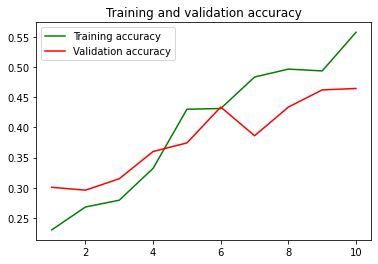

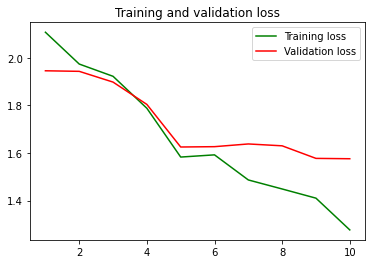

In [91]:
# Plot results
import matplotlib.pyplot as plt

acc = history_LSTM.history['accuracy']
val_acc = history_LSTM.history['val_accuracy']
loss = history_LSTM.history['loss']
val_loss = history_LSTM.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [92]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

14/14 [==============================] - 1s 37ms/step - loss: 1.5759 - accuracy: 0.4645
Test set
  Loss: 1.576
  Accuracy: 0.464


In [93]:
#new complaint 
import numpy as np
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer_obj.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[3.1779724e-01 2.0922042e-02 4.4585797e-01 1.1282952e-02 1.5889177e-01
  2.0111864e-03 1.4179150e-02 9.5821321e-03 1.8072709e-03 4.1724727e-03
  5.9726946e-03 2.8571161e-04 6.5095513e-03 4.9691397e-04 1.4986194e-04
  8.1116224e-05]] Mortgage


In [94]:
#######################################################
#SAMETHING WE WILL DO WITH WORD 2 VEC PRE TRAINED MODEL 
#######################################################


In [95]:
#below steps will remain same 
#text processing 
#making them numrical value defining word_index
#make the sentence of equal length
#convert label to one hot 
#splitting data into train test 


In [96]:
#train test Split :
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print('Shape of X_train_pad:', X_train.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (1688, 80)
Shape of y_train: (1688, 16)
Shape of X_test_pad: (422, 80)
Shape of y_test: (422, 16)


In [97]:
#we will use google word2vec pretrained model 
#here we dont need to train embedding layer as it is already trained we just need to fit that model to
#our requirement for better prediction 


In [98]:

import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [99]:
len(word_index)

5977

In [100]:
embedding_dim=300
#word_index represents number of different word 
#make a  matrix of zeros with rows = numner of words and columns =300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
#if the word is not present in model that we have impoeted then that word vector will be replaced in
#embedding matrix otherwise it will remain 0 as we have defined 

for word, i in word_index.items():
    if word in word2vec_model: 
        embedding_vector = word2vec_model[word]
        embedding_matrix[i] = embedding_vector

In [101]:
#create embedding layer 
#Embedding layer takes input as dimension  i.e number of rows , column =300 ]
#weights wil be the weight matrix as defined above 
#we will make trainable = false as weight matrix is trained already 
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [102]:
model_word2vec = Sequential()
model_word2vec.add(embedding_layer)
model_word2vec.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.25))
model_word2vec.add(Dense(16, activation='softmax'))

model_word2vec.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_word2vec.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 80, 300)           1793400   
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
Total params: 1,836,552
Trainable params: 43,152
Non-trainable params: 1,793,400
_________________________________________________________________
None


In [103]:
history_word2vec = model_word2vec.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=16)

Epoch 1/10
106/106 [==============================] - 45s 426ms/step - loss: 2.2108 - accuracy: 0.2091 - val_loss: 1.9532 - val_accuracy: 0.2630
Epoch 2/10
106/106 [==============================] - 46s 437ms/step - loss: 1.9784 - accuracy: 0.2565 - val_loss: 1.9294 - val_accuracy: 0.2986
Epoch 3/10
106/106 [==============================] - 45s 427ms/step - loss: 1.9457 - accuracy: 0.2749 - val_loss: 1.8930 - val_accuracy: 0.3104
Epoch 4/10
106/106 [==============================] - 47s 441ms/step - loss: 1.9048 - accuracy: 0.2962 - val_loss: 1.8077 - val_accuracy: 0.3104
Epoch 5/10
106/106 [==============================] - 45s 423ms/step - loss: 1.8152 - accuracy: 0.3377 - val_loss: 1.7741 - val_accuracy: 0.3152
Epoch 6/10
106/106 [==============================] - 45s 421ms/step - loss: 1.8507 - accuracy: 0.3335 - val_loss: 2.3418 - val_accuracy: 0.1730
Epoch 7/10
106/106 [==============================] - 46s 438ms/step - loss: 1.8482 - accuracy: 0.3424 - val_loss: 1.7354 - val_ac

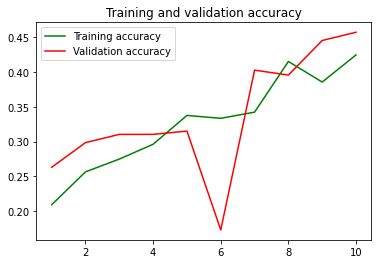

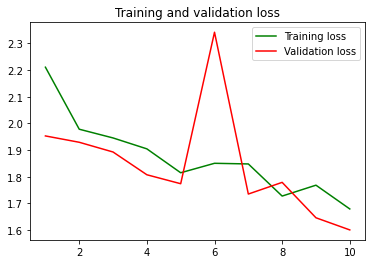

In [104]:
# Plot results
import matplotlib.pyplot as plt

acc = history_word2vec.history['accuracy']
val_acc = history_word2vec.history['val_accuracy']
loss = history_word2vec.history['loss']
val_loss = history_word2vec.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [105]:
accr = model_word2vec.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

14/14 [==============================] - 1s 41ms/step - loss: 1.6010 - accuracy: 0.4573
Test set
  Loss: 1.601
  Accuracy: 0.457


In [106]:
#TEST With a new emotion for classification 
max_length = 55 #this is already defined on top
new_complaint = ["I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX."]
seq = tokenizer_obj.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_length)
pred = model_word2vec.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']

print(pred, labels[np.argmax(pred)])

[[0.29612353 0.02864377 0.14230536 0.06146399 0.22638316 0.0038456
  0.15718172 0.0185937  0.00993205 0.00867266 0.0174504  0.00340115
  0.02128739 0.00373139 0.00035142 0.00063274]] Credit reporting, credit repair services, or other personal consumer reports


In [107]:
#################################################
#LETS TRY THE SAME USING CUSTOM TRAINING WORD2VEC 
#################################################

In [108]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Consumer_Complaints.csv')
#remove all column except input and output 
col = ['Product', 'Consumer Complaint']
df= df[col]
#remove null review comments 
df= df[pd.notnull(df['Consumer Complaint'])]
#rename the column from Consumer Complaint to Consumer_complaint
df.columns=['Product', 'Consumer_complaint']
#factorize the product and rename with categoryid 
df['category_id'] = df['Product'].factorize()[0]
#remove duplicates 
#remove product id 
df =df.drop(df.loc[:,['Product']], axis =1 )
df=df.drop_duplicates()

df.head()

,Consumer_complaint,category_id
1,I have outdated information on my credit repor...,0
2,I purchased a new car on XXXX XXXX. The car de...,1
7,An account on my credit report has a mistaken ...,0
12,This company refuses to provide me verificatio...,2
16,This complaint is in regards to Square Two Fin...,2


In [109]:
def clean_text(df):
    all_reviews = list()
    lines = df["Consumer_complaint"].values.tolist()
    for text in lines:
        text = text.lower()
        text = re.sub('[^a-zA-Z]', ' ', text)
        text = text.replace('x', '')
        #remove single character 
        text = re.sub('\s\w\s',' ',text)
        words=nltk.word_tokenize(text)
        stop_words= set(stopwords.words('english'))
        stop_words.discard("not")
        words_without_stop_words=[word for word in words if word not in stop_words]
        #words=[lemmatizer.lemmatize(word) for word in words_without_stop_words ]
        words=[ps.stem(word) for word in words_without_stop_words ]
        #words = ' '.join(words)
        all_reviews.append(words)
    return all_reviews

all_complaint = clean_text(df)
all_complaint[0:20]

[['outdat',
  'inform',
  'credit',
  'report',
  'previous',
  'disput',
  'yet',
  'remov',
  'inform',
  'seven',
  'year',
  'old',
  'not',
  'meet',
  'credit',
  'report',
  'requir'],
 ['purchas',
  'new',
  'car',
  'car',
  'dealer',
  'call',
  'citizen',
  'bank',
  'get',
  'day',
  'payoff',
  'loan',
  'good',
  'till',
  'dealer',
  'sent',
  'check',
  'net',
  'day',
  'balanc',
  'checkbook',
  'notic',
  'citizen',
  'bank',
  'taken',
  'automat',
  'payment',
  'check',
  'account',
  'bank',
  'call',
  'citizen',
  'state',
  'not',
  'close',
  'loan',
  'state',
  'not',
  'receiv',
  'check',
  'told',
  'not',
  'believ',
  'check',
  'took',
  'long',
  'arriv',
  'told',
  'check',
  'issu',
  'amount',
  'overpaid',
  'deduct',
  'addit',
  'interest',
  'today',
  'call',
  'citizen',
  'bank',
  'talk',
  'supervisor',
  'name',
  'receiv',
  'letter',
  'loan',
  'paid',
  'full',
  'date',
  'refund',
  'check',
  'includ',
  'state',
  'hold',
  'pay

In [110]:
len(all_complaint)

2110

In [111]:
import gensim
model = gensim.models.Word2Vec(sentences=all_complaint, size=100, window=5, workers=4, min_count=1, sg=0) #sg= 1:skip-gram 0:cbow
vocab_words = list(model.wv.vocab)                                                                      
print(len(vocab_words))

5977


In [112]:
#save wordvectors
filename = "/content/drive/My Drive/Colab Notebooks/ConsumerComplaint.txt"
model.wv.save_word2vec_format(filename, binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [113]:
#read and create embedding matrix
embedding_index = {}
f = open(os.path.join('', '/content/drive/My Drive/Colab Notebooks/ConsumerComplaint.txt'),  encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coeff
f.close()

In [114]:
embedding_dim=100
#make a  matrix of zeros with rows = numner of words and columns =300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
#if the word is not present in model that we have impoeted then that word vector will be replaced in
#embedding matrix otherwise it will remain 0 as we have defined 
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [115]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [116]:
# define model
model_own = Sequential()
model_own.add(embedding_layer)
model_own.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.25))
model_own.add(Dense(16, activation='softmax'))

model_own.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_own.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 55, 100)           597800    
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
Total params: 615,352
Trainable params: 17,552
Non-trainable params: 597,800
_________________________________________________________________
None


In [117]:
history_word2vec = model_own.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
27/27 [==============================] - 12s 449ms/step - loss: 2.5931 - accuracy: 0.1996 - val_loss: 2.3425 - val_accuracy: 0.1825
Epoch 2/10
27/27 [==============================] - 11s 424ms/step - loss: 2.1269 - accuracy: 0.2482 - val_loss: 1.9618 - val_accuracy: 0.3223
Epoch 3/10
27/27 [==============================] - 12s 435ms/step - loss: 1.9693 - accuracy: 0.2921 - val_loss: 1.8833 - val_accuracy: 0.3389
Epoch 4/10
27/27 [==============================] - 12s 431ms/step - loss: 1.9002 - accuracy: 0.3134 - val_loss: 1.7871 - val_accuracy: 0.3626
Epoch 5/10
27/27 [==============================] - 12s 426ms/step - loss: 1.7877 - accuracy: 0.3643 - val_loss: 1.7280 - val_accuracy: 0.3578
Epoch 6/10
27/27 [==============================] - 11s 417ms/step - loss: 1.7591 - accuracy: 0.3584 - val_loss: 1.7325 - val_accuracy: 0.3318
Epoch 7/10
27/27 [==============================] - 11s 423ms/step - loss: 1.7805 - accuracy: 0.3483 - val_loss: 1.6414 - val_accuracy: 0.4052

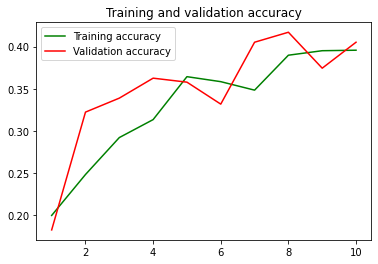

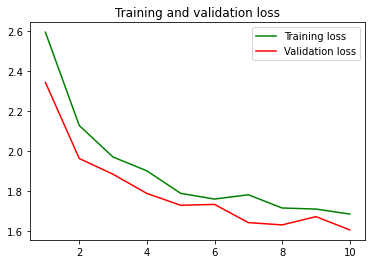

In [118]:
# Plot results
import matplotlib.pyplot as plt

acc = history_word2vec.history['accuracy']
val_acc = history_word2vec.history['val_accuracy']
loss = history_word2vec.history['loss']
val_loss = history_word2vec.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [119]:
accr = model_own.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

14/14 [==============================] - 1s 40ms/step - loss: 1.6049 - accuracy: 0.4052
Test set
  Loss: 1.605
  Accuracy: 0.405


In [120]:
#TEST With a new emotion for classification 
max_length = 55 #this is already defined on top
new_complaint = ["I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX."]
seq = tokenizer_obj.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_length)
pred = model_own.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']

print(pred, labels[np.argmax(pred)])

[[5.5909663e-01 1.9226531e-02 3.2187176e-01 1.9530607e-02 4.4336971e-02
  9.7178196e-04 1.4556923e-02 6.2838863e-03 3.8184568e-03 1.4556745e-03
  2.6542081e-03 3.3113768e-04 4.1460400e-03 4.3868925e-04 7.7965669e-04
  5.0102826e-04]] Credit reporting, credit repair services, or other personal consumer reports
